In [ ]:
!pip3 install librosa

In [69]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from app.website.extract_features import extract_mfcc, zero_crossing_rate

2.5.0


## Dataset

We check given directory to find all available *.wav* files.

In [70]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [71]:
#check source directory and find classes
source_dir = './vox_dev_wav/wav/'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

['id10009', 'id10007', 'id10006', 'id10001', 'id10008', 'id10012', 'id10015', 'id10014', 'id10013', 'id10004', 'id10003', 'id10002', 'id10005', 'id10016', 'id10011', 'id10018', 'id10020', 'id10019', 'id10010', 'id10017']
checking dir: ./vox_dev_wav/wav/id10009/
./vox_dev_wav/wav/id10009/HCGXIgKsozU/
./vox_dev_wav/wav/id10009/AtavJVP4bCk/
./vox_dev_wav/wav/id10009/x_HdUZuSusA/
./vox_dev_wav/wav/id10009/seo9TTTEoE4/
./vox_dev_wav/wav/id10009/7hpSiT9_gCE/
./vox_dev_wav/wav/id10009/JrwqvWr5_VE/
./vox_dev_wav/wav/id10009/FOFbkVlz-wQ/
./vox_dev_wav/wav/id10009/JntZkGsH2Cc/
./vox_dev_wav/wav/id10009/aFttHpeaXaQ/
./vox_dev_wav/wav/id10009/vy8sQ82o0fM/
./vox_dev_wav/wav/id10009/qdop2-gjKBQ/
./vox_dev_wav/wav/id10009/VM8gJWbQsEY/
./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/
./vox_dev_wav/wav/id10009/sQIqfA-I_Ew/
checking dir: ./vox_dev_wav/wav/id10007/
./vox_dev_wav/wav/id10007/10Oe0XETA0s/
./vox_dev_wav/wav/id10007/ny4iV7xwhRM/
./vox_dev_wav/wav/id10007/HxfxcxUXPDA/
./vox_dev_wav/wav/id10007/G0lVD5d0

In [72]:
df = pd.DataFrame(raw)
# df = df[:100]
print(df.shape)
df.head()

(2787, 2)


,speaker,path
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav
1,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00009.wav
2,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00008.wav
3,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00006.wav
4,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00007.wav


## Preprocessing and Feuture Extraction

* We split the dataset as 70% train and 30% test. The split is performed per speaker and not the entire dataset
* Then, we extract MFCC and Delta features

In [73]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.7
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

Train set size: (1950, 2), Test set size (837, 2)


True

In [74]:
# number of mfccs per clip
n_mfcc = splits = 13

df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

In [75]:
# extract Zero Crossing Rate
df_train[['zcr']] = df_train['path'].apply(lambda p: zero_crossing_rate(p, splits))
df_test[['zcr']] = df_test['path'].apply(lambda p: zero_crossing_rate(p, splits))

In [76]:
df_train.head()

,speaker,path,mfcc,delta,zcr
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[-196.19745, 96.77209, -9.442002, 22.09873, -2...","[-0.29390892, -0.18999796, -0.014305613, 0.165...","[0.06953932387458399, 0.13154668067962866, 0.0..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[-385.69135, 122.257576, -14.257886, -23.04002...","[0.08598741, -0.07328853, 0.024153156, 0.01808...","[0.09745702514561727, 0.16309134820286972, 0.0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[-223.81839, 86.769295, -17.60496, 23.541613, ...","[-0.16981685, 0.023842582, 0.12981227, 0.07679...","[0.2788184438040346, 0.25230547550432275, 0.25..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[-159.21338, 96.507286, -21.005232, 2.2055504,...","[-0.1431608, 0.0911606, 0.027648797, 0.0220658...","[0.14064959221633996, 0.1417942481041637, 0.10..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[-204.95496, 92.93275, -16.543903, 7.745483, 2...","[-0.039691795, 0.113837615, -0.073666826, -0.0...","[0.19740464018875345, 0.14195831694848604, 0.1..."


In [77]:
df_test.head()

,speaker,path,mfcc,delta,zcr
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[-196.19745, 96.77209, -9.442002, 22.09873, -2...","[-0.29390892, -0.18999796, -0.014305613, 0.165...","[0.06953932387458399, 0.13154668067962866, 0.0..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[-385.69135, 122.257576, -14.257886, -23.04002...","[0.08598741, -0.07328853, 0.024153156, 0.01808...","[0.09745702514561727, 0.16309134820286972, 0.0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[-223.81839, 86.769295, -17.60496, 23.541613, ...","[-0.16981685, 0.023842582, 0.12981227, 0.07679...","[0.2788184438040346, 0.25230547550432275, 0.25..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[-159.21338, 96.507286, -21.005232, 2.2055504,...","[-0.1431608, 0.0911606, 0.027648797, 0.0220658...","[0.14064959221633996, 0.1417942481041637, 0.10..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[-204.95496, 92.93275, -16.543903, 7.745483, 2...","[-0.039691795, 0.113837615, -0.073666826, -0.0...","[0.19740464018875345, 0.14195831694848604, 0.1..."


In [78]:
#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keep mfcc and delta and zero crossing rate columns
X = df_train.iloc[:,2:5]
# keep speaker colum
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')
# save label encoder to file
np.save('saved_models/classes.npy', le.classes_)
print(type(le))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=21)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list(), X_train['zcr'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(), X_val['delta'].to_list(), X_val['zcr'].to_list()))
print(f'Train set size: {X_train.shape}, Validation set size {X_val.shape}')

Number of speakers is 20
<class 'sklearn.preprocessing._label.LabelEncoder'>
Train set size: (1365, 39), Validation set size (585, 39)


## Deep Learning Model

In [79]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               4000      
_________________________________________________________________
activation_12 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               20200     
_________________________________________________________________
activation_13 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)              

In [80]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 8


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
checkpointer = ModelCheckpoint(filepath='saved_models/speakers_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
171/171 [==============================] - 1s 4ms/step - loss: 21.0180 - accuracy: 0.0930 - val_loss: 2.9275 - val_accuracy: 0.1658

Epoch 00001: val_loss improved from inf to 2.92754, saving model to saved_models/speakers_classification.hdf5
Epoch 2/200
171/171 [==============================] - 0s 3ms/step - loss: 4.7885 - accuracy: 0.0908 - val_loss: 2.9696 - val_accuracy: 0.2188

Epoch 00002: val_loss did not improve from 2.92754
Epoch 3/200
171/171 [==============================] - 0s 3ms/step - loss: 3.3721 - accuracy: 0.1326 - val_loss: 2.9403 - val_accuracy: 0.2188

Epoch 00003: val_loss did not improve from 2.92754
Epoch 4/200
171/171 [==============================] - 0s 3ms/step - loss: 2.9857 - accuracy: 0.1685 - val_loss: 2.8522 - val_accuracy: 0.2188

Epoch 00004: val_loss improved from 2.92754 to 2.85222, saving model to saved_models/speakers_classification.hdf5
Epoch 5/200
171/171 [==============================] - 1s 3ms/step - loss: 2.9923 - accuracy: 0.1

171/171 [==============================] - 1s 5ms/step - loss: 1.9392 - accuracy: 0.4007 - val_loss: 1.6673 - val_accuracy: 0.5060

Epoch 00034: val_loss improved from 1.67369 to 1.66733, saving model to saved_models/speakers_classification.hdf5
Epoch 35/200
171/171 [==============================] - 1s 6ms/step - loss: 1.8443 - accuracy: 0.4271 - val_loss: 1.5979 - val_accuracy: 0.5231

Epoch 00035: val_loss improved from 1.66733 to 1.59794, saving model to saved_models/speakers_classification.hdf5
Epoch 36/200
171/171 [==============================] - 1s 5ms/step - loss: 1.8355 - accuracy: 0.4322 - val_loss: 1.5880 - val_accuracy: 0.5385

Epoch 00036: val_loss improved from 1.59794 to 1.58800, saving model to saved_models/speakers_classification.hdf5
Epoch 37/200
171/171 [==============================] - 2s 10ms/step - loss: 1.8160 - accuracy: 0.4293 - val_loss: 1.5851 - val_accuracy: 0.5368

Epoch 00037: val_loss improved from 1.58800 to 1.58513, saving model to saved_models/speak

171/171 [==============================] - 1s 3ms/step - loss: 1.5884 - accuracy: 0.5172 - val_loss: 1.3631 - val_accuracy: 0.5966

Epoch 00069: val_loss did not improve from 1.29005
Epoch 70/200
171/171 [==============================] - 1s 3ms/step - loss: 1.6919 - accuracy: 0.4923 - val_loss: 1.3501 - val_accuracy: 0.6205

Epoch 00070: val_loss did not improve from 1.29005
Epoch 71/200
171/171 [==============================] - 0s 2ms/step - loss: 1.5859 - accuracy: 0.5194 - val_loss: 1.3353 - val_accuracy: 0.6171

Epoch 00071: val_loss did not improve from 1.29005
Epoch 72/200
171/171 [==============================] - 1s 3ms/step - loss: 1.5406 - accuracy: 0.5055 - val_loss: 1.3126 - val_accuracy: 0.6256

Epoch 00072: val_loss did not improve from 1.29005
Epoch 73/200
171/171 [==============================] - 1s 4ms/step - loss: 1.5161 - accuracy: 0.5216 - val_loss: 1.3660 - val_accuracy: 0.6154

Epoch 00073: val_loss did not improve from 1.29005
Epoch 74/200
171/171 [===========

171/171 [==============================] - 0s 2ms/step - loss: 1.5067 - accuracy: 0.5341 - val_loss: 1.2892 - val_accuracy: 0.6205

Epoch 00109: val_loss did not improve from 1.23898
Epoch 110/200
171/171 [==============================] - 0s 2ms/step - loss: 1.4793 - accuracy: 0.5421 - val_loss: 1.3063 - val_accuracy: 0.6239

Epoch 00110: val_loss did not improve from 1.23898
Epoch 111/200
171/171 [==============================] - 0s 3ms/step - loss: 1.4516 - accuracy: 0.5451 - val_loss: 1.2531 - val_accuracy: 0.6393

Epoch 00111: val_loss did not improve from 1.23898
Epoch 112/200
171/171 [==============================] - 0s 2ms/step - loss: 1.5034 - accuracy: 0.5495 - val_loss: 1.2642 - val_accuracy: 0.6308

Epoch 00112: val_loss did not improve from 1.23898
Epoch 113/200
171/171 [==============================] - 0s 2ms/step - loss: 1.4229 - accuracy: 0.5480 - val_loss: 1.2808 - val_accuracy: 0.6256

Epoch 00113: val_loss did not improve from 1.23898
Epoch 114/200
171/171 [======

171/171 [==============================] - 1s 4ms/step - loss: 1.3600 - accuracy: 0.5597 - val_loss: 1.2335 - val_accuracy: 0.6256

Epoch 00150: val_loss did not improve from 1.21512
Epoch 151/200
171/171 [==============================] - 1s 6ms/step - loss: 1.4068 - accuracy: 0.5663 - val_loss: 1.2529 - val_accuracy: 0.6239

Epoch 00151: val_loss did not improve from 1.21512
Epoch 152/200
171/171 [==============================] - 1s 5ms/step - loss: 1.3798 - accuracy: 0.5656 - val_loss: 1.2291 - val_accuracy: 0.6598

Epoch 00152: val_loss did not improve from 1.21512
Epoch 153/200
171/171 [==============================] - 1s 3ms/step - loss: 1.4026 - accuracy: 0.5597 - val_loss: 1.2675 - val_accuracy: 0.6239

Epoch 00153: val_loss did not improve from 1.21512
Epoch 154/200
171/171 [==============================] - 1s 5ms/step - loss: 1.4209 - accuracy: 0.5590 - val_loss: 1.2122 - val_accuracy: 0.6205

Epoch 00154: val_loss improved from 1.21512 to 1.21220, saving model to saved_mo

### Check training history

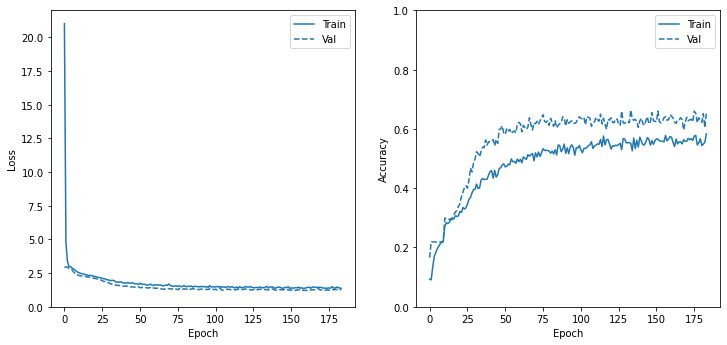

In [81]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

### Predict and Classification Report

In [82]:
from sklearn.metrics import classification_report

X_test = np.hstack((df_test['mfcc'].to_list(),
                    df_test['delta'].to_list(),
                    df_test['zcr'].to_list()))
print(X_test.shape)
y_true = df_test['speaker']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.classes_[y_pred]
print(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))

(837, 39)
['id10004' 'id10009' 'id10004' 'id10004' 'id10003' 'id10003' 'id10003'
 'id10016' 'id10003' 'id10016' 'id10003' 'id10009' 'id10004' 'id10004'
 'id10009' 'id10016' 'id10009' 'id10009' 'id10007' 'id10007' 'id10008'
 'id10007' 'id10007' 'id10001' 'id10007' 'id10007' 'id10007' 'id10007'
 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10007'
 'id10007' 'id10007' 'id10007' 'id10007' 'id10007' 'id10014' 'id10007'
 'id10006' 'id10006' 'id10006' 'id10004' 'id10004' 'id10004' 'id10006'
 'id10004' 'id10018' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006'
 'id10004' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006' 'id10006'
 'id10006' 'id10004' 'id10014' 'id10009' 'id10006' 'id10004' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10014' 'id10006' 'id10006' 'id10006'
 'id10006' 'id10004' 'id10006' 'id10004' 'id10008' 'id10004' 'id10001'
 'id10008' 'id10001' 'id10001' 'id10001' 'id10008' 'id10008' 'id10020'
 'id10001' 'id10001' 'id10008' 'id10003' 'id10008' 'id10008' 'id100

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Gausian Mixture Model

In [83]:
from sklearn import mixture
# fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(X_train)

y_true_gmm = df_test['speaker']

y_pred_gmm = gmm.predict(X_test)
y_pred_gmm = le.classes_[y_pred_gmm]
print(y_pred_gmm)
print(classification_report(y_true_gmm, y_pred_gmm, target_names=le.classes_))

filename = 'saved_models/gaussian_mixture_model.sav'
pickle.dump(gmm, open(filename, 'wb'))


# # display predicted scores by the model as a contour plot
# x = np.linspace(0., 39., 39, endpoint=True)
# # np.linspace(0, 10, N, endpoint=True)
# y = np.linspace(0., 39., 39, endpoint=True)
# X, Y = np.meshgrid(x, y)
# XX = np.array([X.ravel(), Y.ravel()]).T
# Z = -clf.score_samples(XX)
# Z = Z.reshape(X.shape)

# CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
#                  levels=np.logspace(0, 3, 10))
# CB = plt.colorbar(CS, shrink=0.8, extend='both')
# plt.scatter(X_train[:, 0], X_train[:, 1], .8)

# plt.title('Negative log-likelihood predicted by a GMM')
# plt.axis('tight')
# plt.show()


['id10001' 'id10001' 'id10002' 'id10001' 'id10001' 'id10001' 'id10001'
 'id10001' 'id10001' 'id10001' 'id10001' 'id10002' 'id10001' 'id10002'
 'id10002' 'id10002' 'id10001' 'id10001' 'id10002' 'id10001' 'id10001'
 'id10002' 'id10002' 'id10002' 'id10002' 'id10002' 'id10002' 'id10001'
 'id10001' 'id10001' 'id10002' 'id10002' 'id10001' 'id10001' 'id10002'
 'id10001' 'id10001' 'id10001' 'id10002' 'id10002' 'id10001' 'id10002'
 'id10002' 'id10001' 'id10002' 'id10002' 'id10002' 'id10002' 'id10001'
 'id10002' 'id10001' 'id10002' 'id10002' 'id10001' 'id10002' 'id10001'
 'id10002' 'id10002' 'id10001' 'id10002' 'id10001' 'id10001' 'id10001'
 'id10001' 'id10001' 'id10002' 'id10002' 'id10002' 'id10002' 'id10001'
 'id10001' 'id10001' 'id10002' 'id10002' 'id10002' 'id10001' 'id10001'
 'id10002' 'id10001' 'id10002' 'id10002' 'id10002' 'id10001' 'id10001'
 'id10002' 'id10002' 'id10002' 'id10002' 'id10002' 'id10001' 'id10002'
 'id10002' 'id10002' 'id10001' 'id10001' 'id10002' 'id10001' 'id10001'
 'id10

/usr/local/lib/python3.9/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precisio

In [ ]:
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)